In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import pathlib
import os
import zipfile
import seaborn as sns
from multiprocessing import Pool
from src.data.data_prep_utils import df_from_csv_no_geo_extra

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Explore the Different CSVs

In [2]:
# to check CPU count
import multiprocessing
print('CPUs avail:', multiprocessing.cpu_count()) # or os.cpu_count()

# memory available
# https://stackoverflow.com/a/48140392/9214620
!cat /proc/meminfo | grep Mem

CPUs avail: 8
MemTotal:       65801000 kB
MemFree:        52590828 kB
MemAvailable:   59542856 kB


In [3]:
root_dir = Path.cwd().parent
folder_raw_data = root_dir / 'data/raw'
folder_processed_data = root_dir / 'data/processed'
folder_external_data = root_dir / 'data/external'

In [4]:
# get a list of file names
files = os.listdir(folder_raw_data)
file_list = [folder_raw_data / filename for filename in files if filename.endswith('.csv')]
# file_list

The CSV is very large, therefore we will only load certain columns. The columns names are listed in the description pdf. These are the ones we will use for **2003-2004**:
* **dob_yy**: date of birth year
* **dob_mm**: date of birth month
* **dob_wk**: date of birth weekday
* **mrstate**: mother's resident state
* **mrecntyfips**: mother's resident county FIPS code
* **mrcityfips**: mother's place of residence (city) FIPS code
* **apgar5**: five minute Apgar score
* **apgar5r**: five minute Apgar score, recoded

Geographic data is not available from **2005 onwards** (see [column description for 2005 on NBER](https://data.nber.org/natality/2005/desc/natl2005/desc.txt)). Therefore, only these columns will be used.
* **dob_yy**: date of birth year
* **dob_mm**: date of birth month
* **dob_wk**: date of birth weekday
* **apgar5**: five minute Apgar score
* **apgar5r**: five minute Apgar score, recoded


Depending on the year, there are different naming conventions. Here's the ones we'll use for **1989 through 2002** (see [column description for 1989 on NBER](https://data.nber.org/natality/1989/desc/natl1989/desc.txt)):

* **biryr**: date of birth year (can also use 'datayear')
* **birmon**: date of birth month
* **weekday**: date of birth weekday
* **stresfip**: mother's resident state FIPS code
* **cntyrfip**: mother's resident county FIPS code
* **cityres**: mother's place of residence (city) - unsure if fips code
* **fmaps**: five minute Apgar score
* **fmapsr**: five minute Apgar score, recoded


Here's the ones we'll use for 1982 through 1988 (see [column description on NBER](https://data.nber.org/natality/1988/desc/natl1988/desc.txt)):

* **datayear**: date of birth year
* **birmon**: date of birth month
* **birday**: birth date - day (like the 15th of June) (1968-1988 only)
* ~~**weekday**: date of birth weekday~~ (does not exist in this date range)
* **stresfip**: mother's resident state FIPS code
* **cntyrfip**: mother's resident county FIPS code
* **cityres**: mother's place of residence (city) - unsure if fips code
* **fmaps**: five minute Apgar score
* **fmapsr**: five minute Apgar score, recoded

From 1978 onwards, APGAR score is included. (fmaps)

In [6]:
root_dir = Path.cwd().parent
folder_raw_data = root_dir / 'data/raw'
folder_processed_data = root_dir / 'data/processed'
folder_external_data = root_dir / 'data/external'

def main(folder_raw_data):
    """Runs data processing scripts to turn raw data from (../raw) into
    cleaned data ready to be analyzed (saved in ../processed).
    """

    # get a list of file names
    files = os.listdir(folder_raw_data)
    file_list = [
        Path(folder_raw_data) / filename
        for filename in files
        if filename.endswith(".csv")
    ]

    # set up your pool
    with Pool(processes=12) as pool:  # or whatever your hardware can support

        # have your pool map the file names to dataframes
        df_list = pool.map(df_from_csv_no_geo_extra, file_list)

        # reduce the list of dataframes to a single dataframe
        combined_df = pd.concat(df_list, ignore_index=True)

        return combined_df


if __name__ == "__main__":

    # not used in this stub but often useful for finding various files
    project_dir = Path.cwd().parent
    print(type(project_dir))

    df = main(project_dir / "data/raw/")
    print("Final df shape:", df.shape)

    df.to_csv(project_dir / "data/processed" / "birth_no_geo_apgar.csv", index=False)

<class 'pathlib.PosixPath'>
Final df shape: (6048, 4)


In [7]:
df.head()

,dob_yy,dob_mm,apgar5,births
0,2011,1,0,167
1,2011,1,1,720
2,2011,1,10,10864
3,2011,1,2,492
4,2011,1,3,586


# Load Previously Created Data

In [7]:
root_dir = Path.cwd().parent
folder_processed_data = root_dir / 'data/processed'

df = pd.read_csv(folder_processed_data /"birth_no_geo_apgar.csv")
# df = df[df['dob_yy'].isin([1978, 1979])]
df

,dob_yy,dob_mm,apgar5,births
0,2011,1,0,167
1,2011,1,1,720
2,2011,1,10,10864
3,2011,1,2,492
4,2011,1,3,586
...,...,...,...,...
6043,1995,9,6,1498
6044,1995,9,7,3924
6045,1995,9,8,18047
6046,1995,9,9,207028


In [8]:
df = df[df['apgar5']!=99]
df['apgar5'].unique()

array([ 0,  1, 10,  2,  3,  4,  5,  6,  7,  8,  9])

In [9]:
df_count = df.groupby(['dob_yy', 'apgar5']).agg({'births':'sum'})
df_count = df_count.groupby(level=0).apply(lambda x: 100 * x / x.sum())
df_count

births
dob_yy apgar5           
1978   0        0.133359
       1        0.214135
       2        0.171898
       3        0.171254
       4        0.220138
...                  ...
2019   6        0.813538
       7        2.081135
       8       11.153891
       9       82.671713
       10       2.027113

[462 rows x 1 columns]

In [10]:
df_count = df_count.reset_index().rename(columns={'births':'births_pct'})
df_count.head()

,dob_yy,apgar5,births_pct
0,1978,0,0.133359
1,1978,1,0.214135
2,1978,2,0.171898
3,1978,3,0.171254
4,1978,4,0.220138


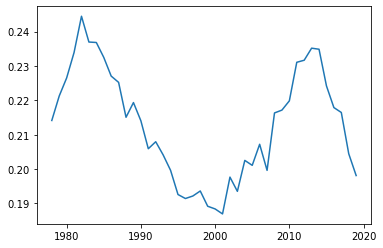

In [11]:
# plot the apgar5 distribution by year
df_a = df_count[df_count['apgar5']==1]

plt.plot(df_a['dob_yy'], df_a['births_pct'])

In [12]:
# plot the "births_pct" distribution by year all on the same plot
df_b = df_count[df_count['apgar5']==2]

In [13]:
years = np.sort(df_count['dob_yy'].unique())
years

array([1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988,
       1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
       2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

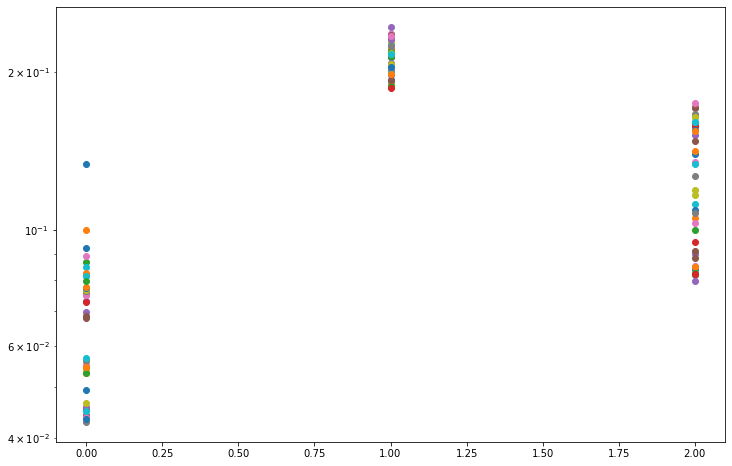

In [14]:
fig, ax = plt.subplots(figsize=(12,8))
for year in np.sort(df_count['dob_yy'].unique()):
    df_year = df_count[(df_count['dob_yy']==year) & (df_count['apgar5']<3) 
    # & (df_count['apgar5']<6)
    ]
    ax.scatter(df_year['apgar5'], df_year['births_pct'], label=year)

# set y-axis to log scale
ax.set_yscale('log')


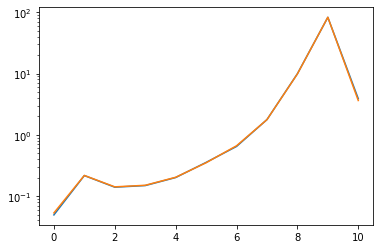

In [15]:
plt.plot(df_count[df_count['dob_yy']==2008]['apgar5'], df_count[df_count['dob_yy']==2008]['births_pct'],)
plt.plot(df_count[df_count['dob_yy']==2009]['apgar5'], df_count[df_count['dob_yy']==2009]['births_pct'],)

# change the y-axis scale to log
plt.yscale('log')
# plt.plot(df_count[df_count['dob_yy']==2009]['births_pct'], df_count[df_count['dob_yy']==2009]['apgar5'])

How can we best see if the apgar score is changing over time?
* Heatmap of the apgar score by year or month?
* Should we measure the change in apgar score as a percentage of change over some average?

Let's start working on the heatmap.

## Heatmap Experiment

In [27]:
root_dir = Path.cwd().parent
folder_processed_data = root_dir / 'data/processed'

df = pd.read_csv(folder_processed_data /"birth_no_geo_apgar.csv")
# df = df[df['dob_yy'].isin([1978, 1979])]
df

,dob_yy,dob_mm,apgar5,births
0,2011,1,0,167
1,2011,1,1,720
2,2011,1,10,10864
3,2011,1,2,492
4,2011,1,3,586
...,...,...,...,...
6043,1995,9,6,1498
6044,1995,9,7,3924
6045,1995,9,8,18047
6046,1995,9,9,207028


In [28]:
df = df[df['apgar5']!=99]
df['apgar5'].unique()

df_count = df.groupby(['dob_yy', 'dob_mm', 'apgar5']).agg({'births':'sum'})
df_count = df_count.groupby(level=0).apply(lambda x: 100 * x / x.sum())
df_count = df_count.reset_index().rename(columns={'births':'births_pct'})
df_count.head()

,dob_yy,dob_mm,apgar5,births_pct
0,1978,1,0,0.039772
1,1978,1,1,0.015383
2,1978,1,2,0.012007
3,1978,1,3,0.012435
4,1978,1,4,0.015759


In [42]:
flights = sns.load_dataset("flights")
flights.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [38]:
flights = flights.pivot("month", "year", "passengers")
flights

year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
month,,,,,,,,,,,,
Jan,112,115,145,171,196,204,242,284,315,340,360,417
Feb,118,126,150,180,196,188,233,277,301,318,342,391
Mar,132,141,178,193,236,235,267,317,356,362,406,419
Apr,129,135,163,181,235,227,269,313,348,348,396,461
May,121,125,172,183,229,234,270,318,355,363,420,472
Jun,135,149,178,218,243,264,315,374,422,435,472,535
Jul,148,170,199,230,264,302,364,413,465,491,548,622
Aug,148,170,199,242,272,293,347,405,467,505,559,606
Sep,136,158,184,209,237,259,312,355,404,404,463,508


In [41]:
df_count

,dob_yy,dob_mm,apgar5,births_pct
0,1978,1,0,0.039772
1,1978,1,1,0.015383
2,1978,1,2,0.012007
3,1978,1,3,0.012435
4,1978,1,4,0.015759
...,...,...,...,...
5539,2019,12,6,0.064442
5540,2019,12,7,0.175158
5541,2019,12,8,0.923667
5542,2019,12,9,6.817719


<AxesSubplot:xlabel='dob_mm', ylabel='dob_yy'>

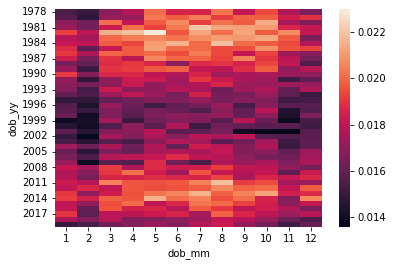

In [45]:
sns.heatmap(df_count[df_count['apgar5'] == 1][['dob_yy', 'dob_mm', 'births_pct']].pivot('dob_yy', 'dob_mm', 'births_pct'))

# Scratch
https://www.kite.com/python/answers/how-to-generate-percentages-of-pandas-columns-in-python

In [14]:
dfp = df.groupby(['dob_yy', 'dob_mm', 'apgar5'], as_index=False).agg({'births': 'sum'})
dfp

,dob_yy,dob_mm,apgar5,births
0,1978,1,0,742
1,1978,1,1,287
2,1978,1,2,224
3,1978,1,3,232
4,1978,1,4,294
...,...,...,...,...
127,1978,12,6,1304
128,1978,12,7,3012
129,1978,12,8,12425
130,1978,12,9,83733


In [16]:
dp_perc = dfp.groupby(level=0,).apply(lambda x : 100.0 * x / x.sum())
dp_perc

,dob_yy,dob_mm,apgar5,births
0,100.0,100.0,NaN,100.0
1,100.0,100.0,100.0,100.0
2,100.0,100.0,100.0,100.0
3,100.0,100.0,100.0,100.0
4,100.0,100.0,100.0,100.0
...,...,...,...,...
127,100.0,100.0,100.0,100.0
128,100.0,100.0,100.0,100.0
129,100.0,100.0,100.0,100.0
130,100.0,100.0,100.0,100.0


In [42]:
dp_perc[dp_perc['dob_yy']==1978]

KeyError: 'dob_yy'

In [19]:
desc = df.describe()
desc

,dob_yy,dob_mm,apgar5,births
count,5544.000000,5544.000000,5544.000000,5544.000000
mean,1998.500000,6.500000,5.000000,24836.663240
std,12.122012,3.452364,3.162563,62602.179936
min,1978.000000,1.000000,0.000000,104.000000
25%,1988.000000,3.750000,2.000000,393.750000
50%,1998.500000,6.500000,5.000000,834.000000
75%,2009.000000,9.250000,8.000000,11979.250000
max,2019.000000,12.000000,10.000000,325076.000000


In [13]:
a = list(df['dob_yy'].unique()).sort()
a

In [ ]:
unique

In [12]:
year = 1968

df = df_from_csv_no_geo_extra(folder_raw_data / f'natl{str(year)}.csv', nrows=2000)
df

,dob_yy,dob_mm,apgar5,births


In [37]:
df[(df['dob_yy']==1989) & (df['apgar5']==1) & (df['dob_mm']==1)]['apgar5']

0    1
Name: apgar5, dtype: int64

In [29]:
df.dtypes

dob_yy    int64
dob_mm    int64
apgar5    int64
births    int64
dtype: object

In [11]:
df = pd.DataFrame(columns=["dob_yy", "dob_mm", "apgar5", "births"])
df

,dob_yy,dob_mm,apgar5,births


In [9]:
# columns for 2003 through 2004
col_load_1 = ['dob_yy','dob_mm','dob_wk','mrstate','mrcntyfips','mrcityfips', 'apgar5']
col_1_dtype = [int, int, int, str, int, int, int]

# columns for 1989 through 2002
col_load_2 =['biryr', 'birmon', 'weekday', 'stresfip', 'cntyrfip', 'cityres']

# columns for 2005+
col_load_3 =['dob_yy','dob_mm','dob_wk']

# columns for 1982 through 1988
col_load_4 =['datayear', 'birmon','birday','stresfip', 'cntyrfip', 'cityres']
rename_col4 = ['dob_yy','dob_mm','dob_day','mrstate','mrcntyfips','mrcityfips',]

# create dictionary to rename older csvs
col_rename_dict = dict(zip(col_load_2, col_load_1))
col_rename_dict4 = dict(zip(col_load_4, rename_col4))
col_rename_dict

{'biryr': 'dob_yy',
 'birmon': 'dob_mm',
 'weekday': 'dob_wk',
 'stresfip': 'mrstate',
 'cntyrfip': 'mrcntyfips',
 'cityres': 'mrcityfips'}

Load csv from 1972. This does not have any geographic data...

In [30]:
year = 1972
df = pd.read_csv(folder_raw_data / f'natl{str(year)}.csv', nrows=1, usecols=['datayear', 'birmon','birday',], dtype=str).rename(columns=col_rename_dict4)
# df = df.rename(columns={'mrstate':'mrstatefips'})
df.head()

,dob_yy,dob_mm,dob_day
0,2,1,20


Load "older" csv (from 1991-2002)

In [10]:
year = 1993
df = pd.read_csv(folder_raw_data / f'natl{str(year)}.csv', nrows=1, usecols=col_load_2, dtype=str).rename(columns=col_rename_dict)
df = df.rename(columns={'mrstate':'mrstatefips'})
df.head()

,mrcityfips,mrstatefips,mrcntyfips,dob_mm,dob_yy,dob_wk
0,999,01,01999,1,1993,2


In [11]:
# load 'all-geocodes-v2017.xlsx'
# df_fips = pd.read_csv('./other_data/all-geocodes-v2017.csv', 
#                         dtype={'State Code (FIPS)': int, 
#                                'County Code (FIPS)': int, 
#                                'County Subdivision Code (FIPS)': int, 
#                                'Place Code (FIPS)': int, 
#                                'Consolidtated City Code (FIPS)': int})

df_fips = pd.read_csv(folder_external_data / 'all-geocodes-v2017.csv', dtype=str)

df_fips.head()

,Summary Level,State Code (FIPS),County Code (FIPS),County Subdivision Code (FIPS),Place Code (FIPS),Consolidtated City Code (FIPS),Area Name (including legal/statistical area description)
0,010,00,000,00000,00000,00000,United States
1,040,01,000,00000,00000,00000,Alabama
2,050,01,001,00000,00000,00000,Autauga County
3,050,01,003,00000,00000,00000,Baldwin County
4,050,01,005,00000,00000,00000,Barbour County


In [12]:
# get the fips codes for the states only
# df_state_fips = df_fips[(df_fips['State Code (FIPS)']>0) & 
#                         (df_fips['County Code (FIPS)']==0) & 
#                         (df_fips['County Subdivision Code (FIPS)']==0) & 
#                         (df_fips['Place Code (FIPS)']==0) & 
#                         (df_fips['Consolidtated City Code (FIPS)']==0)
#                        ][['State Code (FIPS)','Area Name (including legal/statistical area description)']]


df_state_fips = df_fips[(df_fips['County Code (FIPS)']=='000') & 
                        (df_fips['County Subdivision Code (FIPS)']=='00000') & 
                        (df_fips['Place Code (FIPS)']=='00000') & 
                        (df_fips['Consolidtated City Code (FIPS)']=='00000')
                       ][['State Code (FIPS)','Area Name (including legal/statistical area description)']]

# rename columns in df
df_state_fips.columns = ['state_fips', 'state_name_mr']
df_state_fips.head()

,state_fips,state_name_mr
0,00,United States
1,01,Alabama
530,02,Alaska
708,04,Arizona
815,05,Arkansas


In [13]:
df = pd.merge(df, df_state_fips, left_on='mrstatefips',
              right_on='state_fips', how='inner', copy=False).drop(['state_fips'], axis=1).drop(['mrstatefips'], axis=1)
df.head()

,mrcityfips,mrcntyfips,dob_mm,dob_yy,dob_wk,state_name_mr
0,999,01999,1,1993,2,Alabama


In [14]:
# change the dtype for the numerical columns
df = df.astype({'dob_mm':int, 'dob_wk':int, 'dob_yy':int})
df.head()

,mrcityfips,mrcntyfips,dob_mm,dob_yy,dob_wk,state_name_mr
0,999,01999,1,1993,2,Alabama


Load 1982-1988.

In [15]:
year = 1982
df = pd.read_csv(folder_raw_data / f'natl{str(year)}.csv', nrows=1, usecols=col_load_4, dtype=str).rename(columns=col_rename_dict4)
df = df.rename(columns={'mrstate':'mrstatefips'})
df.head()

,dob_yy,mrcityfips,dob_mm,dob_day,mrstatefips,mrcntyfips
0,2,999,1,2,01,01001


In [16]:
df = pd.merge(df, df_state_fips, left_on='mrstatefips',
              right_on='state_fips', how='inner', copy=False).drop(['state_fips'], axis=1).drop(['mrstatefips'], axis=1)
df.head()

,dob_yy,mrcityfips,dob_mm,dob_day,mrcntyfips,state_name_mr
0,2,999,1,2,01001,Alabama


Load 2005+.

In [32]:
year = 2007

# columns for 2005+
col_load_3 =['dob_yy','dob_mm','dob_wk',]
# col_load_3 =['dob_yy','dob_mm','dob_wk', 'ocntyfips']

df = pd.read_csv(folder_raw_data / f'natl{str(year)}.csv', nrows=1, usecols=col_load_3, dtype=str)
df

,dob_yy,dob_mm,dob_wk,ocntyfips
0,2007,1,5,NaN
1,2007,1,4,NaN
2,2007,1,7,NaN
3,2007,1,4,NaN
4,2007,1,6,NaN
5,2007,1,5,NaN
6,2007,1,4,NaN
7,2007,1,2,NaN
8,2007,1,2,NaN
9,2007,1,2,NaN


Load 2003-2004 csv.

In [18]:
year = 2003
df = pd.read_csv(folder_raw_data / f'natl{str(year)}.csv', nrows=1, usecols=col_load_1, dtype=str)
df

,dob_yy,dob_mm,dob_wk,mrstate,mrcntyfips,mrcityfips,apgar5,apgar5r
0,2003,1,4,AK,999,99999,10,4


In [19]:
# load 'state_abbreviations.csv'
df_abbr = pd.read_csv(folder_external_data / 'state_abbreviations.csv',header=None, names=['state','abbr'])
df_abbr.head()

,state,abbr
0,Alabama,AL
1,Alaska,AK
2,American Samoa,AS
3,Arizona,AZ
4,Arkansas,AR


In [20]:
# use pandas merge. Also, dorp the 'abbr' columns right away
df = pd.merge(df, df_abbr, left_on='mrstate',right_on='abbr', how='inner', copy=False).drop(['abbr'], axis=1).drop(['mrstate'], axis=1)
df = df.rename(columns={'state':'state_name_mr'})
df = df.astype({'dob_mm':int, 'dob_wk':int, 'dob_yy':int})
df.head()

,dob_yy,dob_mm,dob_wk,mrcntyfips,mrcityfips,apgar5,apgar5r,state_name_mr
0,2003,1,4,999,99999,10,4,Alaska


In [21]:
# add state fips code
df = pd.merge(df, df_state_fips, left_on='state_name_mr',
              right_on='state_name_mr', how='inner', copy=False)
df = df.rename(columns={'state_fips':'mrstatefips'})
df.head()

,dob_yy,dob_mm,dob_wk,mrcntyfips,mrcityfips,apgar5,apgar5r,state_name_mr,mrstatefips
0,2003,1,4,999,99999,10,4,Alaska,02


Practice grouping a table together by birth year/month/week-day.

In [22]:
year = 2005

# columns for 2005+
col_load_3 =['dob_yy','dob_mm','dob_wk',]

df = pd.read_csv(folder_raw_data / f'natl{str(year)}.csv', nrows=100, usecols=col_load_3, dtype=int)
df.head()

,dob_yy,dob_mm,dob_wk
0,2005,1,3
1,2005,1,4
2,2005,1,7
3,2005,1,7
4,2005,1,7


In [23]:
df.shape

(100, 3)

In [24]:
df['births'] = np.ones(df.shape[0])
df1 = df.groupby(['dob_yy', 'dob_mm', 'dob_wk'], as_index=False).count().sort_values(by=['dob_yy','dob_mm','dob_wk'])
df1[:10]

,dob_yy,dob_mm,dob_wk,births
0,2005,1,1,11
1,2005,1,2,16
2,2005,1,3,17
3,2005,1,4,15
4,2005,1,5,14
5,2005,1,6,7
6,2005,1,7,20


The final dataframe is much smaller - only 84 rows.

In [7]:
df.columns

Index(['dob_yy', 'dob_mm', 'mrcntyfips', 'mrcityfips', 'state_name_mr',
       'mrstatefips', 'apgar5', 'births'],
      dtype='object')

In [8]:
# load the data
root_dir = Path.cwd().parent
data_file = "birth_geo_births_ind_test.csv.gz"

dtype_dict = {'dob_yy':int, 'dob_mm':int, 'mrcntyfips':str, 'mrcityfips':str, 'state_name_mr':str,
       'mrstatefips':int, 'apgar5':int, 'births':int}

df = pd.read_csv(root_dir / data_file, compression='gzip', dtype=dtype_dict)
df.head()

,dob_yy,dob_mm,mrcntyfips,mrcityfips,state_name_mr,mrstatefips,apgar5,births
0,1989,1,01999,999,Alabama,1,10,1
1,1989,1,01999,999,Alabama,1,9,1
2,1989,1,01999,999,Alabama,1,8,1
3,1989,1,01999,999,Alabama,1,9,1
4,1989,1,01999,999,Alabama,1,9,1


In [12]:
np.sort(df['dob_yy'].unique())

array([1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004])

In [15]:
df.shape

(89598797, 8)

In [16]:
data_file = "birth_geo_births_summed_test.csv.gz"

dtype_dict = {'dob_yy':int, 'dob_mm':int, 'mrcntyfips':str, 'mrcityfips':str, 'state_name_mr':str,
       'mrstatefips':int, 'apgar5':int, 'births':int}

df = pd.read_csv(root_dir / data_file, compression='gzip', dtype=dtype_dict)
df.head()

,dob_yy,dob_mm,mrcntyfips,mrcityfips,state_name_mr,mrstatefips,births
0,1982,1,00000,ZZZ,United States,0,483
1,1982,1,01001,999,Alabama,1,44
2,1982,1,01003,999,Alabama,1,90
3,1982,1,01005,999,Alabama,1,33
4,1982,1,01007,999,Alabama,1,22


In [17]:
df.shape

(409414, 7)